# Introduction to Sorted Adaptive Prediction Sets (SAPS) for Conformal Prediction

## 1. Introduction to Conformal Prediction(vlt auslassen)?


## 2. Motivation 




In general, CP algorithms use a non-conformity score to quantify the deviation of a new instance and the training data, which determines the size of the prediction set. A higher score indicates lower prediction confidence and result in a larger prediction set.

Methods like **Adaptive Prediction Sets (APS)** calculates this score by accumulating the sorted softmax calues. However, the softmax probalities typically exhibit a long-tailed distribution, allowing for easy inclusion of those tail classes in the prediction sets. 

**Regularized Adaptive Prediction Sets (RAPS)** exclude unlikely classes using by using a penalty. Nevertheless, RAPS's score still relies on these unreliable softmax probabilites, often leading to suboptimal performance.

This motivates our question: *Does the probability value play a critical role in conformal prediction?*

The following bar chart illustrates the dramatic reduction in set size when the probability value is removed.

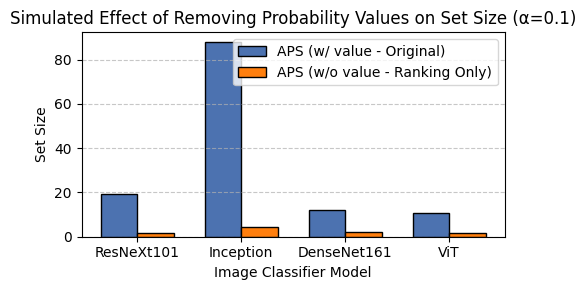

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Simulated Data from Paper (Figure 1b) ---
# Data is simulated based on the results for various models on ImageNet (alpha=0.1)
# Note: The original figure uses 7 models, here we use 4 representative models for simplicity.
models = ["ResNeXt101", "Inception", "DenseNet161", "ViT"]

# Simulated Average Set Size (alpha=0.1)
# 'w/ value' corresponds to the vanilla APS score
set_size_w_value = np.array([19.49, 87.93, 12.03, 10.55])
# 'w/o value' corresponds to APS without probability values (only ranking)
set_size_wo_value = np.array([1.82, 4.58, 2.08, 1.61])

# --- Plotting ---

# Set figure and bar width
fig, ax = plt.subplots(figsize=(5, 3))
bar_width = 0.35
index = np.arange(len(models))

# Create bars
bar1 = ax.bar(
    index - bar_width / 2,
    set_size_w_value,
    bar_width,
    label="APS (w/ value - Original)",
    color="#4c72b0",
    edgecolor="black",
)
bar2 = ax.bar(
    index + bar_width / 2,
    set_size_wo_value,
    bar_width,
    label="APS (w/o value - Ranking Only)",
    color="#ff7f0e",
    edgecolor="black",
)

# Add labels, title, and customize
ax.set_xlabel("Image Classifier Model")
ax.set_ylabel("Set Size")
ax.set_title("Simulated Effect of Removing Probability Values on Set Size (a=0.1)")
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 3. The Sorted Adaptive Prediction Sets Algorithm

SAPS is an algorithm designed to minimize the dependence of the non-conformity score on probability values while retaining uncertainty information.

***But you might ask yourself: what's different from the other established Conformal Prediction methods?***

In short:

APS focuses on all softmax values. \
RAPS focuses on all softmax values and the penalty.\
SAPS focuses on the rank and the Max Softmax (MSP).

SAPS discards all probability values except for the **Maximum Softmax Probability (MSP)** ($\hat{\pi}_{\max}(x)$) , which is used to measure model confidence. The non-maximum probability values are essentially replaced by a ranking information.



The non-conformity score of SAPS for a data pair (x,y) can be calculated as 
 
 $$
 S_{\text{saps}}(x,y,u; \hat{\pi}) :=
 \begin{cases}
 u· \hat{\pi}_{\text{max}}(x),\;
 if \;  o(y, \hat{\pi}(x)) = 1, \\
 π_{\text{max}}(x) +(o(y, \hat{\pi}(x)) − 2 + u)·λ, \;
 else
 \end{cases}

 

***To give you a quick overview:***

$o(y, \hat{\pi}(x))$ = the rank index of the true label's softmax probability \
$λ$ = is a hyperparameter representing the weight of ranking information \
$ \hat{\pi}_{\text{max}}(x) $ = the Maximum Softmax Probability  \
$u$ = is a uniform random variable



In particular, the score for the top-ranked label (MSP) is equivalent to that of APS for the label with the maximum softmax prbability, while the scores of the resting labels are composed of MSP and the ranking information from 2 to $o(y, \hat{\pi}(x))$, for example $(o(y, \hat{\pi}(x)) − 2 + u)$ . 

In this way, the new score of SAPS retains instance-wise uncertainty and mitigates the undesirable influence of tail probabilites. 

## 4. Examples


This section demonstrates SAPS's performance based on the paper's findings with a focus on set size (efficiency) and coverage rate (validity), using simulated results from the **ImageNet** dataset.

In [20]:
# --- Simulated Data from Paper (Average performance from Table 1) ---
# Data simulates the average results across all models for different alpha values. ImageNet dataset.

# Metrics: [Coverage (Target 0.900), Set Size (Target Low)]
results_a01 = {
    "APS": [0.899, 20.95],
    "RAPS": [0.900, 3.29],
    "SAPS": [0.900, 2.98],
}

# Metrics: [Coverage (Target 0.950), Set Size (Target Low)]
results_a005 = {
    "APS": [0.949, 44.67],
    "RAPS": [0.950, 8.57],
    "SAPS": [0.950, 7.55],
}


def format_table(title: str, data: dict) -> str:
    """Generates a clearly formatted table string."""
    output = f"### {title}\n"

    # Header
    output += f"{'Method':<8} | {'Coverage':<20} | {'Set Size (↓)':<20}\n"
    output += "-" * 50 + "\n"

    # Find the minimum set size for highlighting (best efficiency)
    min_size = min(data[method][1] for method in data)

    # Rows
    for method, metrics in data.items():
        coverage = f"{metrics[0]:.3f}"
        set_size = f"{metrics[1]:.2f}"

        # Add highlight indicator for the best result
        highlight = " (BEST)" if metrics[1] == min_size else ""

        output += f"{method:<8} | {coverage:<20} | {set_size + highlight:<20}\n"

    return output


# Generate output for both alpha levels
output_a01 = format_table("SAPS Performance (Simulated) - Error Rate a=0.1", results_a01)
output_a005 = format_table("SAPS Performance (Simulated) - Error Rate a=0.05", results_a005)

# Print the results
print(output_a01)
print("\n")
print(output_a005)

print("\n--- Data Generation Complete ---")

### SAPS Performance (Simulated) - Error Rate a=0.1
Method   | Coverage             | Set Size (↓)        
--------------------------------------------------
APS      | 0.899                | 20.95               
RAPS     | 0.900                | 3.29                
SAPS     | 0.900                | 2.98 (BEST)         



### SAPS Performance (Simulated) - Error Rate a=0.05
Method   | Coverage             | Set Size (↓)        
--------------------------------------------------
APS      | 0.949                | 44.67               
RAPS     | 0.950                | 8.57                
SAPS     | 0.950                | 7.55 (BEST)         


--- Data Generation Complete ---


### **Key Takeaways from SAPS Analysis**

The analysis confirms the design principles of SAPS are highly effective:

* Superior Efficency: The SAPS algorithm significantly reduces the average prediction set size compared to both APS and RAPS, demonstrating a superior efficiency-coverage trade-off.
* Enhanced Validity: SAPS not only maintains the desired marginal coverage rate ($\approx 1-\alpha$), but also broadly enhances **conditional coverage rate** and adaptivity to instance difficulty, ensuring set sizes are smaller for "easy" examples and larger for "hard" examples.
* Role of Calibration: Achieving the most compact prediction sets requires proper **Confidences Calibration** (such as through Temperateure Scaling), which improves the reliability of the retained **Maximum Softmax Probablity**, a key component of the SAPS non-conformity score. 




## 5. Conclusion

The **Sorted Adaptive Prediction Sets (SAPS)** algorithm provides an elegant and highly efficient solution for generating valid prediction sets within the Conformal Prediction framework. 

# Implementation in Probly
